# Industrial Waste Sorting Systems

## Function to save Plots

In [1]:
# code to save the figures as high-res PNGs
import os
from pathlib import Path
from matplotlib import pyplot as plt

IMAGES_PATH = Path() / "Images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Split Dataset into Train/Validation/Test Sections

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_data(source_dir, dest_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    assert train_ratio + val_ratio + test_ratio == 1, "Train, val and test ratios must sum to 1."

    # Create destination directories
    for subset in ['train', 'val', 'test']:
        for class_name in ['Recyclable', 'Compostable', 'Landfill']:
            os.makedirs(os.path.join(dest_dir, subset, class_name), exist_ok=True)
    
    # Split and copy files
    for class_name in ['Recyclable', 'Compostable', 'Landfill']:
        class_path = os.path.join(source_dir, class_name)
        files = os.listdir(class_path)
        
        train_files, temp_files = train_test_split(files, train_size=train_ratio, random_state=42)
        val_files, test_files = train_test_split(temp_files, test_size=test_ratio/(val_ratio + test_ratio), random_state=42)

        for file_set, subset in zip([train_files, val_files, test_files], ['train', 'val', 'test']):
            for file in file_set:
                src = os.path.join(class_path, file)
                dst = os.path.join(dest_dir, subset, class_name, file)
                shutil.copy(src, dst)
                
    print('Dataset splitted successfully.')

source_dir = 'Dataset/'
dest_dir = 'Dataset/'
split_data(source_dir, dest_dir)

Dataset splitted successfully.


## Plot: Number of Images per Class Used for the System Development

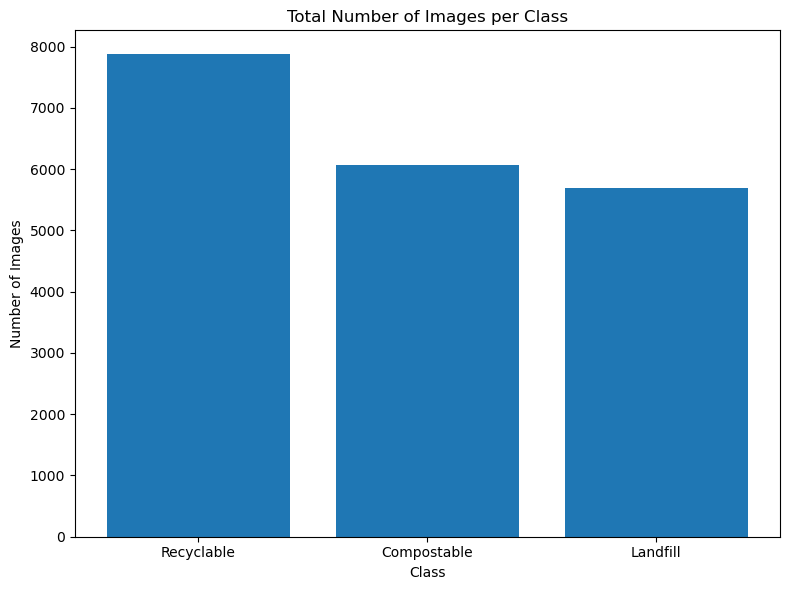

In [3]:
import os
import matplotlib.pyplot as plt

source_dir = 'Dataset/'
class_counts = {}

# List the folders (classes)
classes = ['Recyclable', 'Compostable', 'Landfill']

for class_name in classes:
    class_dir = os.path.join(source_dir, class_name)
    class_counts[class_name] = len([name for name in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, name))])

# Plotting the counts
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Total Number of Images per Class')
save_fig('Total Number of Images per Class')
plt.show()

## Plot: Images count per set

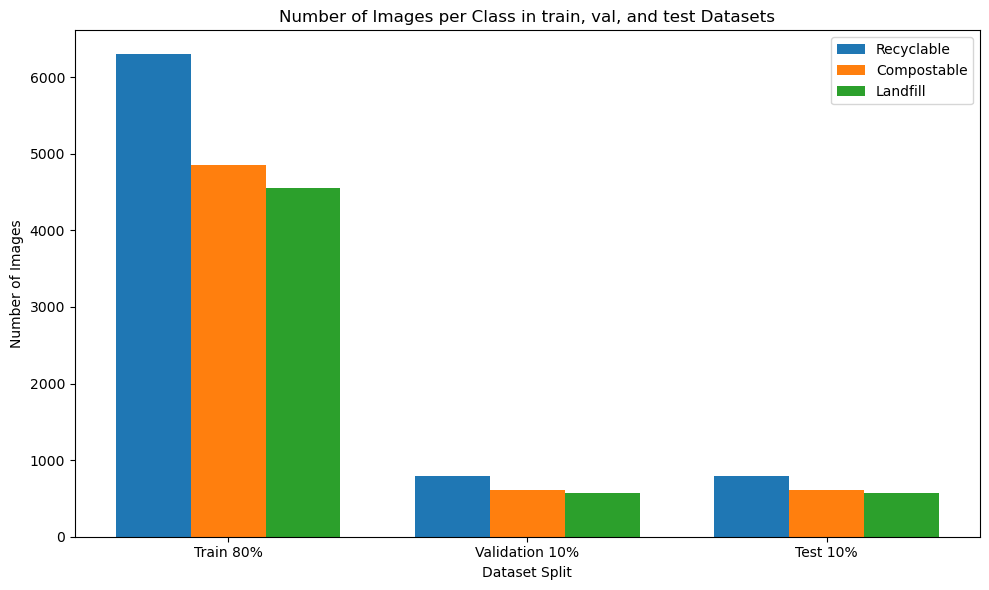

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

# directories
directories = {
    'train': 'Dataset/train',
    'val': 'Dataset/val',
    'test': 'Dataset/test'
}

all_counts = {'Recyclable': [], 'Compostable': [], 'Landfill': []}

# Loop over the directories and classes
for dir_name, source_dir in directories.items():
    for class_name in all_counts.keys():
        class_dir = os.path.join(source_dir, class_name)
        # Count the number of images in the class folder
        count = len([name for name in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, name))])
        all_counts[class_name].append(count)

# Plotting the counts for each directory using bars
x_labels = ['Train 80%', 'Validation 10%', 'Test 10%']
x = np.arange(len(x_labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each class
for i, (class_name, counts) in enumerate(all_counts.items()):
    ax.bar(x + i*width, counts, width, label=class_name)

# Plot configs
ax.set_xlabel('Dataset Split')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images per Class in train, val, and test Datasets')
ax.set_xticks(x + width)
ax.set_xticklabels(x_labels)
ax.legend()

# plt.grid(True)
save_fig('Train-Val-Test Count Plot')
plt.show()

## Pre-processing Section

### Dataloader Pipeline

In [5]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def create_train_val_test_dataloaders(data_dir, batch_size, num_workers=4):
    # Define specific transformations for each dataset
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((244, 244)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
        'val': transforms.Compose([
            transforms.Resize((244, 244)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
        'test': transforms.Compose([
            transforms.Resize((244, 244)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
    }

    # Create datasets using specific transformations
    image_datasets = {
        'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']),
        'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val']),
        'test': datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test'])
    }

    # Create dataloaders
    dataloaders = {
        'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
        'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=num_workers),
        'test': DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
    }

    return dataloaders

### Switching to GPU Utilization Mood

In [6]:
import torch
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Define CNN Models

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

def load_resnet50(num_classes):
    model =  models.resnet50(weights='ResNet50_Weights.DEFAULT')
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model

def load_efficientnet_b0(num_classes):
    model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, num_classes)
    return model

def load_mobilenet_v2(num_classes):
    model = models.mobilenet_v2(weights='MobileNet_V2_Weights.DEFAULT')
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, num_classes)
    return model

def load_mobilenet_v3_large(num_classes):
    model = models.mobilenet_v3_large(weights='MobileNet_V3_Large_Weights.DEFAULT')
    num_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(num_features, num_classes)
    return model

def load_mobilenet_v3_small(num_classes):
    model = models.mobilenet_v3_small(weights='MobileNet_V3_Small_Weights.DEFAULT')
    num_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(num_features, num_classes)
    return model

### Model Training Section

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

class ModelTrainer:
    def __init__(self, model, dataloaders, criterion, optimizer, num_epochs, save_dir):
        self.model = model
        self.dataloaders = dataloaders
        self.criterion = criterion
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.save_dir = save_dir
        
        # Lists to store loss and accuracy values
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def train(self):
        # Create directory for saving models if it doesn't exist
        os.makedirs(self.save_dir, exist_ok=True)

        train_loader = self.dataloaders['train']
        val_loader = self.dataloaders['val']

        for epoch in range(self.num_epochs):
            # Training phase
            self.model.train()
            running_train_loss = 0.0
            correct_train = 0
            total_train = 0

            for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{self.num_epochs} - Training'):
                inputs, labels = inputs.to(device), labels.to(device)

                self.optimizer.zero_grad()

                outputs = self.model(inputs)  # Output shape: [batch_size, num_classes]
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_train_loss += loss.item() * inputs.size(0)

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
                correct_train += (predicted == labels).sum().item()
                total_train += labels.size(0)

            train_loss = running_train_loss / len(train_loader.dataset)
            train_acc = correct_train / total_train

            # Validation phase
            self.model.eval()
            running_val_loss = 0.0
            correct_val = 0
            total_val = 0

            with torch.no_grad():
                for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{self.num_epochs} - Validation'):
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)

                    running_val_loss += loss.item() * inputs.size(0)

                    # Calculate accuracy
                    _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
                    correct_val += (predicted == labels).sum().item()
                    total_val += labels.size(0)

            val_loss = running_val_loss / len(val_loader.dataset)
            val_acc = correct_val / total_val

            # Store loss and accuracy values
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)

            # Print epoch statistics
            print(f'Epoch [{epoch+1}/{self.num_epochs}] - '
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%')

            # Save the model after each epoch
            torch.save(self.model.state_dict(), os.path.join(self.save_dir, f'model_epoch_{epoch+1}.pth'))

        print('Training complete.')

    def plot_learning_curves(self, fig_name):
        plt.figure(figsize=(12, 6))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(range(1, len(self.train_losses) + 1), self.train_losses, label='Train Loss')
        plt.plot(range(1, len(self.val_losses) + 1), self.val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Curve')
        plt.legend()

        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(self.train_accuracies) + 1), self.train_accuracies, label='Train Accuracy')
        plt.plot(range(1, len(self.val_accuracies) + 1), self.val_accuracies, label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Curve')
        plt.legend()

        plt.tight_layout()
        plt.savefig(fig_name)
        plt.show()

### Train: ResNet50

Epoch 1/10 - Training:   0%|                                                                   | 0/491 [00:00<?, ?it/s]C:\Users\User\anaconda3\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Epoch 1/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:15<00:00,  4.04it/s]


Epoch [1/10] - Train Loss: 0.4589, Train Acc: 82.78%, Val Loss: 0.4029, Val Acc: 84.92%


Epoch 2/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:15<00:00,  4.07it/s]


Epoch [2/10] - Train Loss: 0.3076, Train Acc: 88.63%, Val Loss: 0.3975, Val Acc: 85.99%


Epoch 3/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:15<00:00,  4.09it/s]


Epoch [3/10] - Train Loss: 0.2369, Train Acc: 91.58%, Val Loss: 0.1952, Val Acc: 93.63%


Epoch 4/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.15it/s]


Epoch [4/10] - Train Loss: 0.1858, Train Acc: 93.26%, Val Loss: 0.2808, Val Acc: 89.05%


Epoch 5/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:15<00:00,  4.11it/s]


Epoch [5/10] - Train Loss: 0.1677, Train Acc: 94.22%, Val Loss: 0.2579, Val Acc: 90.58%


Epoch 6/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:15<00:00,  4.11it/s]


Epoch [6/10] - Train Loss: 0.1300, Train Acc: 95.27%, Val Loss: 0.3105, Val Acc: 91.14%


Epoch 7/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.17it/s]


Epoch [7/10] - Train Loss: 0.0971, Train Acc: 96.54%, Val Loss: 0.2236, Val Acc: 92.61%


Epoch 8/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:15<00:00,  4.08it/s]


Epoch [8/10] - Train Loss: 0.0930, Train Acc: 96.65%, Val Loss: 0.4193, Val Acc: 87.32%


Epoch 9/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.16it/s]


Epoch [9/10] - Train Loss: 0.0817, Train Acc: 97.08%, Val Loss: 0.1983, Val Acc: 94.19%


Epoch 10/10 - Validation: 100%|████████████████████████████████████████████████████████| 62/62 [00:14<00:00,  4.16it/s]


Epoch [10/10] - Train Loss: 0.0757, Train Acc: 97.48%, Val Loss: 0.2220, Val Acc: 93.79%
Training complete.


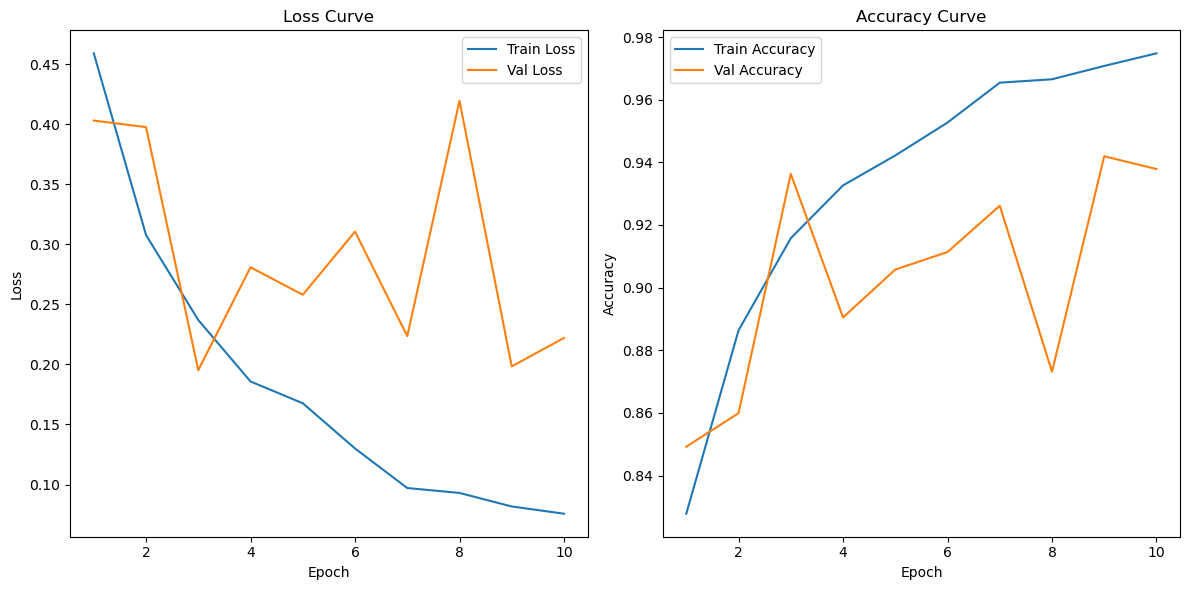

In [9]:
data_dir = 'Dataset/'
batch_size = 32
dataloaders = create_train_val_test_dataloaders(data_dir, batch_size)
model = load_resnet50(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create an instance of ModelTrainer
trainer = ModelTrainer(
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    save_dir='Checkpoints/resnet50'
)

# Train the model
trainer.train()

# Plot learning curves
trainer.plot_learning_curves('learning_curves_resnet50')

### Train: Mobilenet_v3_large

Epoch 1/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.78it/s]


Epoch [1/10] - Train Loss: 0.3110, Train Acc: 88.53%, Val Loss: 0.3701, Val Acc: 86.35%


Epoch 2/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.82it/s]


Epoch [2/10] - Train Loss: 0.1896, Train Acc: 93.60%, Val Loss: 0.9096, Val Acc: 85.58%


Epoch 3/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.82it/s]


Epoch [3/10] - Train Loss: 0.1430, Train Acc: 95.19%, Val Loss: 0.2212, Val Acc: 92.77%


Epoch 4/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.90it/s]


Epoch [4/10] - Train Loss: 0.1157, Train Acc: 95.99%, Val Loss: 0.2367, Val Acc: 92.56%


Epoch 5/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.91it/s]


Epoch [5/10] - Train Loss: 0.1122, Train Acc: 95.99%, Val Loss: 0.1567, Val Acc: 94.91%


Epoch 6/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.80it/s]


Epoch [6/10] - Train Loss: 0.0819, Train Acc: 97.38%, Val Loss: 0.2114, Val Acc: 93.28%


Epoch 7/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.88it/s]


Epoch [7/10] - Train Loss: 0.0701, Train Acc: 97.59%, Val Loss: 0.1974, Val Acc: 94.75%


Epoch 8/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.83it/s]


Epoch [8/10] - Train Loss: 0.0667, Train Acc: 97.64%, Val Loss: 0.2320, Val Acc: 91.70%


Epoch 9/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.77it/s]


Epoch [9/10] - Train Loss: 0.1202, Train Acc: 96.17%, Val Loss: 0.1693, Val Acc: 95.98%


Epoch 10/10 - Validation: 100%|████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.84it/s]


Epoch [10/10] - Train Loss: 0.0641, Train Acc: 97.92%, Val Loss: 0.1234, Val Acc: 96.64%
Training complete.


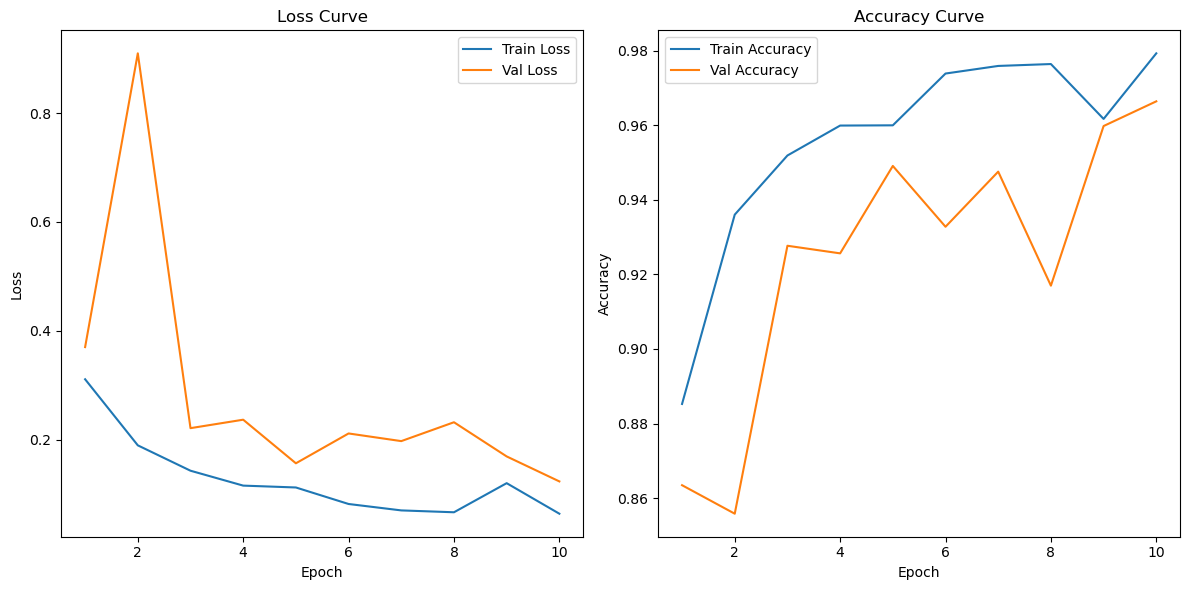

In [11]:
data_dir = 'Dataset/'
batch_size = 32
dataloaders = create_train_val_test_dataloaders(data_dir, batch_size)
model = load_mobilenet_v3_large(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create an instance of ModelTrainer
trainer = ModelTrainer(
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    save_dir='Checkpoints/mobilenet_v3_large'
)

# Train the model
trainer.train()

# Plot learning curves
trainer.plot_learning_curves('learning_curves_mobilenet_v3_large')

### Train: Mobilenet_v3_large 20 Epoch

Epoch 1/20 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.89it/s]


Epoch [1/20] - Train Loss: 0.3146, Train Acc: 88.63%, Val Loss: 0.3373, Val Acc: 89.05%


Epoch 2/20 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.86it/s]


Epoch [2/20] - Train Loss: 0.1749, Train Acc: 93.89%, Val Loss: 0.2177, Val Acc: 92.51%


Epoch 3/20 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.69it/s]


Epoch [3/20] - Train Loss: 0.1300, Train Acc: 95.36%, Val Loss: 0.2919, Val Acc: 91.39%


Epoch 4/20 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.77it/s]


Epoch [4/20] - Train Loss: 0.1093, Train Acc: 96.20%, Val Loss: 0.2194, Val Acc: 92.61%


Epoch 5/20 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.93it/s]


Epoch [5/20] - Train Loss: 0.0935, Train Acc: 96.68%, Val Loss: 0.2223, Val Acc: 93.84%


Epoch 6/20 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.79it/s]


Epoch [6/20] - Train Loss: 0.0863, Train Acc: 97.13%, Val Loss: 0.1412, Val Acc: 95.62%


Epoch 7/20 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.84it/s]


Epoch [7/20] - Train Loss: 0.0864, Train Acc: 97.07%, Val Loss: 0.1892, Val Acc: 94.09%


Epoch 8/20 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.83it/s]


Epoch [8/20] - Train Loss: 0.0890, Train Acc: 96.89%, Val Loss: 0.1570, Val Acc: 95.06%


Epoch 9/20 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.89it/s]


Epoch [9/20] - Train Loss: 0.0579, Train Acc: 98.03%, Val Loss: 0.1548, Val Acc: 95.06%


Epoch 10/20 - Validation: 100%|████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.90it/s]


Epoch [10/20] - Train Loss: 0.0571, Train Acc: 98.07%, Val Loss: 0.1538, Val Acc: 95.52%


Epoch 11/20 - Validation: 100%|████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.97it/s]


Epoch [11/20] - Train Loss: 0.0666, Train Acc: 97.73%, Val Loss: 0.1155, Val Acc: 96.03%


Epoch 12/20 - Validation: 100%|████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.97it/s]


Epoch [12/20] - Train Loss: 0.0414, Train Acc: 98.48%, Val Loss: 0.2252, Val Acc: 94.24%


Epoch 13/20 - Validation: 100%|████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.79it/s]


Epoch [13/20] - Train Loss: 0.0724, Train Acc: 97.61%, Val Loss: 0.2447, Val Acc: 93.22%


Epoch 14/20 - Validation: 100%|████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.88it/s]


Epoch [14/20] - Train Loss: 0.0506, Train Acc: 98.25%, Val Loss: 0.1711, Val Acc: 94.85%


Epoch 15/20 - Validation: 100%|████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.85it/s]


Epoch [15/20] - Train Loss: 0.0372, Train Acc: 98.64%, Val Loss: 0.1994, Val Acc: 95.31%


Epoch 16/20 - Validation: 100%|████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.84it/s]


Epoch [16/20] - Train Loss: 0.0336, Train Acc: 98.78%, Val Loss: 0.2331, Val Acc: 95.21%


Epoch 17/20 - Validation: 100%|████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.98it/s]


Epoch [17/20] - Train Loss: 0.0555, Train Acc: 98.26%, Val Loss: 1.0416, Val Acc: 78.66%


Epoch 18/20 - Validation: 100%|████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  5.02it/s]


Epoch [18/20] - Train Loss: 0.0382, Train Acc: 98.68%, Val Loss: 0.1922, Val Acc: 94.70%


Epoch 19/20 - Validation: 100%|████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.87it/s]


Epoch [19/20] - Train Loss: 0.0328, Train Acc: 98.79%, Val Loss: 0.2178, Val Acc: 93.73%


Epoch 20/20 - Validation: 100%|████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.84it/s]


Epoch [20/20] - Train Loss: 0.0490, Train Acc: 98.36%, Val Loss: 0.1685, Val Acc: 95.82%
Training complete.


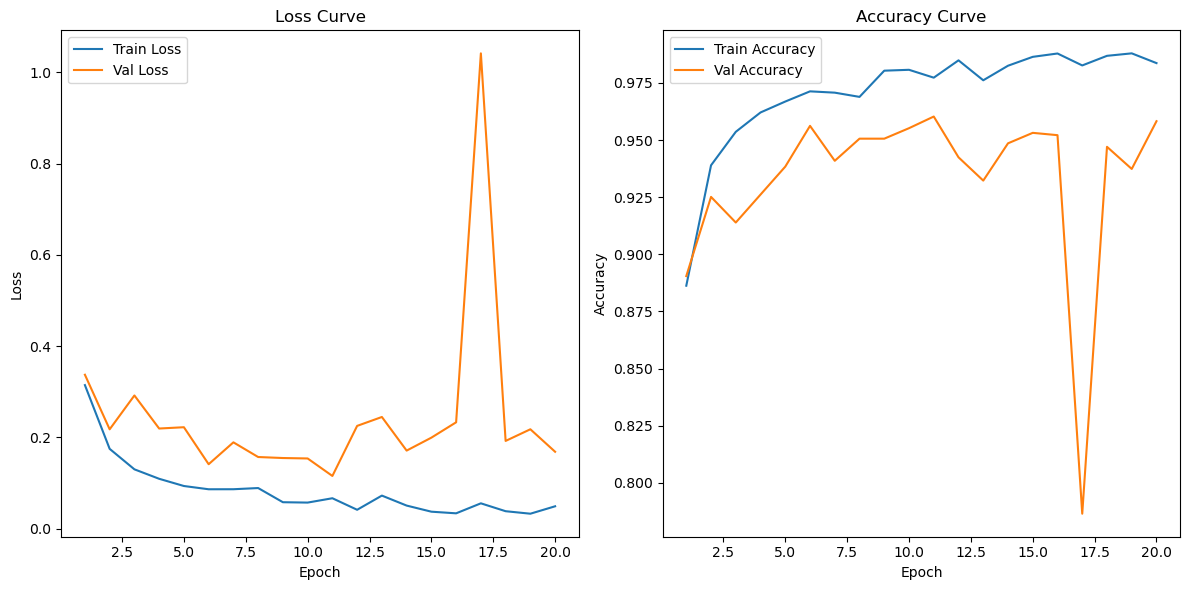

In [12]:
data_dir = 'Dataset/'
batch_size = 32
dataloaders = create_train_val_test_dataloaders(data_dir, batch_size)
model = load_mobilenet_v3_large(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create an instance of ModelTrainer
trainer = ModelTrainer(
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=20,
    save_dir='Checkpoints/mobilenet_v3_large_20ep'
)

# Train the model
trainer.train()

# Plot learning curves
trainer.plot_learning_curves('learning_curves_mobilenet_v3_large_20ep')

### Train: Efficientnet_b0

Epoch 1/20 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.75it/s]


Epoch [1/20] - Train Loss: 0.3391, Train Acc: 87.69%, Val Loss: 0.1757, Val Acc: 94.45%


Epoch 2/20 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.79it/s]


Epoch [2/20] - Train Loss: 0.1966, Train Acc: 93.31%, Val Loss: 0.1657, Val Acc: 94.40%


Epoch 3/20 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.72it/s]


Epoch [3/20] - Train Loss: 0.1561, Train Acc: 94.50%, Val Loss: 0.1402, Val Acc: 95.98%


Epoch 4/20 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.64it/s]


Epoch [4/20] - Train Loss: 0.1294, Train Acc: 95.59%, Val Loss: 0.1841, Val Acc: 94.09%


Epoch 5/20 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.66it/s]


Epoch [5/20] - Train Loss: 0.0991, Train Acc: 96.44%, Val Loss: 0.1028, Val Acc: 96.69%


Epoch 6/20 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.68it/s]


Epoch [6/20] - Train Loss: 0.0975, Train Acc: 96.65%, Val Loss: 0.1626, Val Acc: 95.16%


Epoch 7/20 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.71it/s]


Epoch [7/20] - Train Loss: 0.0843, Train Acc: 97.06%, Val Loss: 0.1253, Val Acc: 96.18%


Epoch 8/20 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.77it/s]


Epoch [8/20] - Train Loss: 0.0712, Train Acc: 97.54%, Val Loss: 0.1172, Val Acc: 96.28%


Epoch 9/20 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.75it/s]


Epoch [9/20] - Train Loss: 0.0659, Train Acc: 97.89%, Val Loss: 0.1321, Val Acc: 96.13%


Epoch 10/20 - Validation: 100%|████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.75it/s]


Epoch [10/20] - Train Loss: 0.0656, Train Acc: 97.80%, Val Loss: 0.1725, Val Acc: 95.77%


Epoch 11/20 - Validation: 100%|████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.71it/s]


Epoch [11/20] - Train Loss: 0.0706, Train Acc: 97.79%, Val Loss: 0.1071, Val Acc: 96.99%


Epoch 12/20 - Validation: 100%|████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.67it/s]


Epoch [12/20] - Train Loss: 0.0567, Train Acc: 98.13%, Val Loss: 0.1219, Val Acc: 95.77%


Epoch 13/20 - Validation: 100%|████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.64it/s]


Epoch [13/20] - Train Loss: 0.0515, Train Acc: 98.34%, Val Loss: 0.1823, Val Acc: 95.52%


Epoch 14/20 - Validation: 100%|████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.79it/s]


Epoch [14/20] - Train Loss: 0.0486, Train Acc: 98.36%, Val Loss: 0.0906, Val Acc: 97.20%


Epoch 15/20 - Validation: 100%|████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.82it/s]


Epoch [15/20] - Train Loss: 0.0395, Train Acc: 98.69%, Val Loss: 0.1547, Val Acc: 95.77%


Epoch 16/20 - Validation: 100%|████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.76it/s]


Epoch [16/20] - Train Loss: 0.0549, Train Acc: 98.27%, Val Loss: 0.1506, Val Acc: 96.03%


Epoch 17/20 - Validation: 100%|████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.74it/s]


Epoch [17/20] - Train Loss: 0.0379, Train Acc: 98.87%, Val Loss: 0.1374, Val Acc: 96.13%


Epoch 18/20 - Validation: 100%|████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.70it/s]


Epoch [18/20] - Train Loss: 0.0450, Train Acc: 98.54%, Val Loss: 0.1916, Val Acc: 94.29%


Epoch 19/20 - Validation: 100%|████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.73it/s]


Epoch [19/20] - Train Loss: 0.0360, Train Acc: 98.88%, Val Loss: 0.1203, Val Acc: 96.54%


Epoch 20/20 - Validation: 100%|████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.64it/s]


Epoch [20/20] - Train Loss: 0.0556, Train Acc: 98.12%, Val Loss: 0.1516, Val Acc: 96.18%
Training complete.


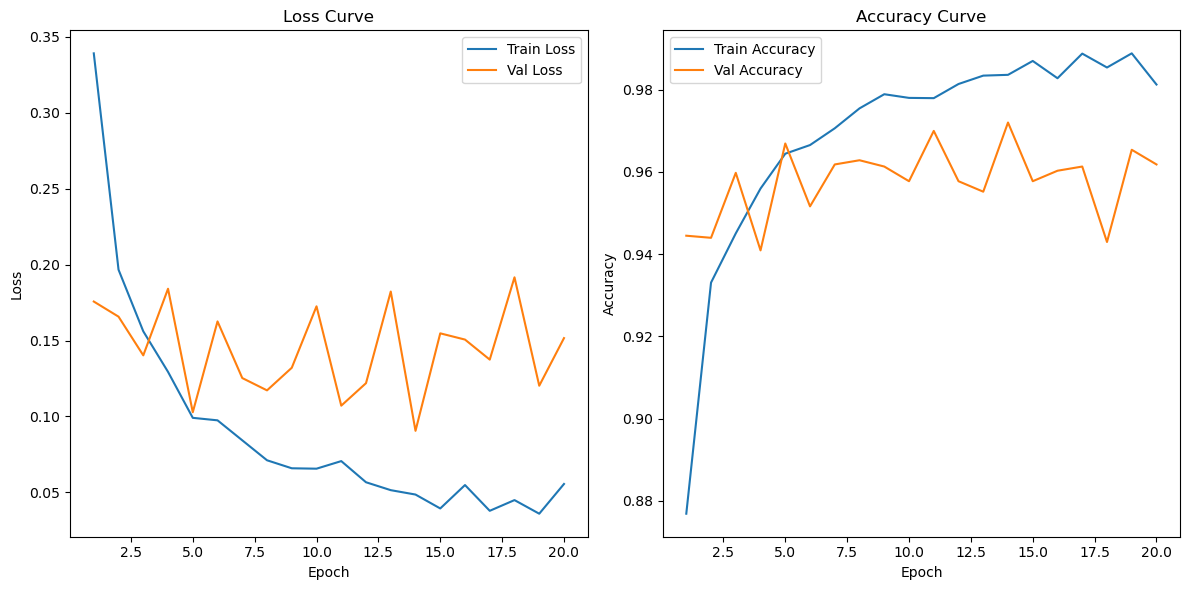

In [13]:
data_dir = 'Dataset/'
batch_size = 32
dataloaders = create_train_val_test_dataloaders(data_dir, batch_size)
model = load_efficientnet_b0(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create an instance of ModelTrainer
trainer = ModelTrainer(
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=20,
    save_dir='Checkpoints/efficientnet_b0'
)

# Train the model
trainer.train()

# Plot learning curves
trainer.plot_learning_curves('learning_curves_efficientnet_b0p')

### Train: MobileNet_v2

Epoch 1/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.79it/s]


Epoch [1/10] - Train Loss: 0.3408, Train Acc: 87.46%, Val Loss: 0.2111, Val Acc: 92.72%


Epoch 2/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.80it/s]


Epoch [2/10] - Train Loss: 0.2182, Train Acc: 92.49%, Val Loss: 0.1668, Val Acc: 94.19%


Epoch 3/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.84it/s]


Epoch [3/10] - Train Loss: 0.1659, Train Acc: 94.14%, Val Loss: 0.1577, Val Acc: 94.24%


Epoch 4/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.75it/s]


Epoch [4/10] - Train Loss: 0.1323, Train Acc: 95.31%, Val Loss: 0.1540, Val Acc: 94.04%


Epoch 5/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.79it/s]


Epoch [5/10] - Train Loss: 0.1192, Train Acc: 95.86%, Val Loss: 0.2125, Val Acc: 93.79%


Epoch 6/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.79it/s]


Epoch [6/10] - Train Loss: 0.1082, Train Acc: 96.36%, Val Loss: 0.1811, Val Acc: 94.60%


Epoch 7/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.67it/s]


Epoch [7/10] - Train Loss: 0.0957, Train Acc: 96.82%, Val Loss: 0.1392, Val Acc: 95.42%


Epoch 8/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.75it/s]


Epoch [8/10] - Train Loss: 0.0837, Train Acc: 97.09%, Val Loss: 0.1542, Val Acc: 94.85%


Epoch 9/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.73it/s]


Epoch [9/10] - Train Loss: 0.0828, Train Acc: 97.16%, Val Loss: 0.1973, Val Acc: 93.79%


Epoch 10/10 - Validation: 100%|████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.75it/s]


Epoch [10/10] - Train Loss: 0.0753, Train Acc: 97.50%, Val Loss: 0.1448, Val Acc: 95.57%
Training complete.


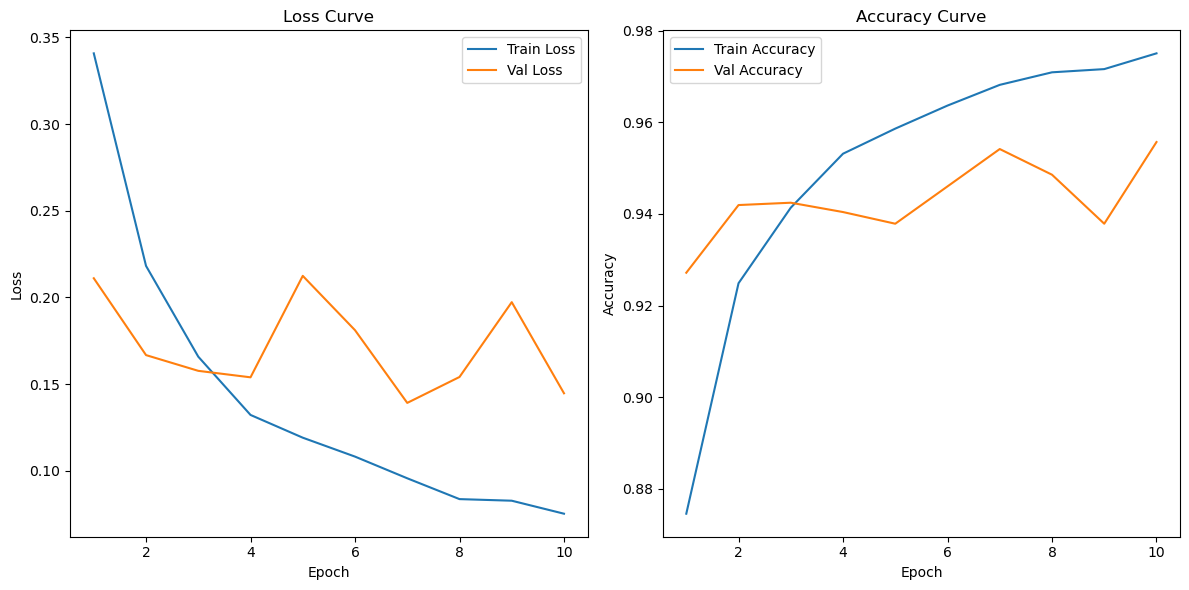

In [15]:
data_dir = 'Dataset/'
batch_size = 32
dataloaders = create_train_val_test_dataloaders(data_dir, batch_size)
model = load_mobilenet_v2(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create an instance of ModelTrainer
trainer = ModelTrainer(
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    save_dir='Checkpoints/mobilenet_v2'
)

# Train the model
trainer.train()

# Plot learning curves
trainer.plot_learning_curves('learning_curves_mobilenet_v2')

### Train: MobileNet_v3_small

Epoch 1/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.75it/s]


Epoch [1/10] - Train Loss: 0.3422, Train Acc: 87.28%, Val Loss: 0.2845, Val Acc: 89.96%


Epoch 2/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.97it/s]


Epoch [2/10] - Train Loss: 0.1971, Train Acc: 92.85%, Val Loss: 0.2444, Val Acc: 91.44%


Epoch 3/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.85it/s]


Epoch [3/10] - Train Loss: 0.1455, Train Acc: 94.73%, Val Loss: 0.2323, Val Acc: 91.85%


Epoch 4/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.83it/s]


Epoch [4/10] - Train Loss: 0.1163, Train Acc: 95.84%, Val Loss: 0.2034, Val Acc: 93.38%


Epoch 5/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.77it/s]


Epoch [5/10] - Train Loss: 0.0903, Train Acc: 96.84%, Val Loss: 0.1564, Val Acc: 94.80%


Epoch 6/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.82it/s]


Epoch [6/10] - Train Loss: 0.0817, Train Acc: 97.15%, Val Loss: 0.1435, Val Acc: 95.47%


Epoch 7/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.85it/s]


Epoch [7/10] - Train Loss: 0.0703, Train Acc: 97.48%, Val Loss: 0.2377, Val Acc: 93.38%


Epoch 8/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.80it/s]


Epoch [8/10] - Train Loss: 0.0668, Train Acc: 97.61%, Val Loss: 0.2245, Val Acc: 93.68%


Epoch 9/10 - Validation: 100%|█████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.92it/s]


Epoch [9/10] - Train Loss: 0.0631, Train Acc: 97.90%, Val Loss: 0.3024, Val Acc: 91.75%


Epoch 10/10 - Validation: 100%|████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.81it/s]


Epoch [10/10] - Train Loss: 0.0661, Train Acc: 97.78%, Val Loss: 0.2151, Val Acc: 93.79%
Training complete.


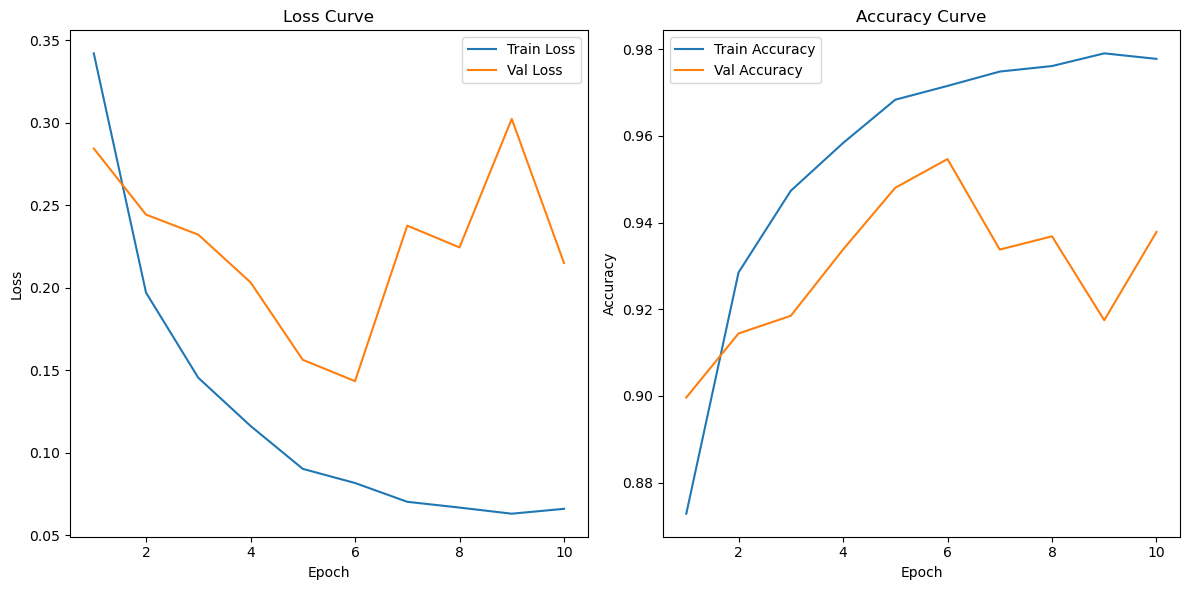

In [16]:
data_dir = 'Dataset/'
batch_size = 32
dataloaders = create_train_val_test_dataloaders(data_dir, batch_size)
model = load_mobilenet_v3_small(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create an instance of ModelTrainer
trainer = ModelTrainer(
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    save_dir='Checkpoints/mobilenet_v3_small'
)

# Train the model
trainer.train()

# Plot learning curves
trainer.plot_learning_curves('learning_curves_mobilenet_v3_small')

## Model Testing Section

In [22]:
import torch

# Move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Load Test Dataset

In [23]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def create_test_dataloader(data_dir, batch_size, num_workers=4):
    # Define transformations for the test dataset
    data_transform = transforms.Compose([
        transforms.Resize((244, 244)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Create the test dataset
    test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=data_transform)

    # Create the test dataloader
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return test_loader

data_dir = 'Dataset/'
batch_size = 32
test_loader = create_test_dataloader(data_dir, batch_size)

In [24]:
from torch import nn
from torchvision import models
from tqdm import tqdm

# Function to load the model
def load_model(model_class, checkpoint_path, num_classes):
    model = model_class(num_classes=num_classes)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()
    return model

def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1) 
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_loss = test_loss / len(test_loader.dataset)
    test_acc = correct / total
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%')

In [31]:
# List of model loading functions
model_functions = [
    load_resnet50,
    load_mobilenet_v3_large,
    load_mobilenet_v3_large,
    load_efficientnet_b0,
    load_mobilenet_v2,
    load_mobilenet_v3_small,
]

checkpoint_paths = [
    'Checkpoints/resnet50/model_epoch_9.pth',
    'Checkpoints/mobilenet_v3_large/model_epoch_10.pth',
    'Checkpoints/mobilenet_v3_large_20ep/model_epoch_11.pth',
    'Checkpoints/efficientnet_b0/model_epoch_14.pth',
    'Checkpoints/mobilenet_v2/model_epoch_7.pth',
    'Checkpoints/mobilenet_v3_small/model_epoch_6.pth',
]

In [32]:
num_classes = 3
loss_fn = nn.CrossEntropyLoss()

for get_model, checkpoint_path in zip(model_functions, checkpoint_paths):
    # Load the model using the function
    loaded_model = load_model(get_model, checkpoint_path, num_classes)
    loaded_model = loaded_model.to(device)
    # Evaluate the loaded model on the test set
    print(checkpoint_path)
    evaluate_model(loaded_model, test_loader, loss_fn)

Checkpoints/resnet50/model_epoch_9.pth


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 62/62 [00:15<00:00,  3.97it/s]


Test Loss: 0.2127, Test Accuracy: 94.30%
Checkpoints/mobilenet_v3_large/model_epoch_10.pth


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.84it/s]


Test Loss: 0.1742, Test Accuracy: 95.42%
Checkpoints/mobilenet_v3_large_20ep/model_epoch_11.pth


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.85it/s]


Test Loss: 0.1659, Test Accuracy: 94.86%
Checkpoints/efficientnet_b0/model_epoch_14.pth


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.57it/s]


Test Loss: 0.1549, Test Accuracy: 95.78%
Checkpoints/mobilenet_v2/model_epoch_7.pth


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.67it/s]


Test Loss: 0.1662, Test Accuracy: 94.86%
Checkpoints/mobilenet_v3_small/model_epoch_6.pth


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 62/62 [00:12<00:00,  4.79it/s]

Test Loss: 0.1687, Test Accuracy: 94.55%


# Benchmarking Test

## Switching to GPU

In [1]:
import torch

# Move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Define CNN Models

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

def load_resnet50(num_classes):
    model =  models.resnet50(weights='ResNet50_Weights.DEFAULT')
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model

def load_efficientnet_b0(num_classes):
    model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, num_classes)
    return model

def load_mobilenet_v2(num_classes):
    model = models.mobilenet_v2(weights='MobileNet_V2_Weights.DEFAULT')
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, num_classes)
    return model

def load_mobilenet_v3_large(num_classes):
    model = models.mobilenet_v3_large(weights='MobileNet_V3_Large_Weights.DEFAULT')
    num_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(num_features, num_classes)
    return model

def load_mobilenet_v3_small(num_classes):
    model = models.mobilenet_v3_small(weights='MobileNet_V3_Small_Weights.DEFAULT')
    num_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(num_features, num_classes)
    return model

## Load Benchmarking Test Dataset

In [3]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def create_test_dataloader(data_dir, batch_size, num_workers=4):
    # Define transformations for the test dataset
    data_transform = transforms.Compose([
        transforms.Resize((244, 244)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Create the test dataset
    test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'Benchmarking'), transform=data_transform)

    # Create the test dataloader
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return test_loader

data_dir = 'Dataset/'
batch_size = 32
test_loader = create_test_dataloader(data_dir, batch_size)

In [4]:
from torch import nn
from torchvision import models
from tqdm import tqdm

# Function to load the model
def load_model(model_class, checkpoint_path, num_classes):
    model = model_class(num_classes=num_classes)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()
    return model

# Function to test the model
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1) 
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_loss = test_loss / len(test_loader.dataset)
    test_acc = correct / total
    print(f'Loss: {test_loss:.4f}, Accuracy: {test_acc*100:.2f}%')

In [5]:
# List of model loading functions
model_functions = [
    load_resnet50,
    load_mobilenet_v3_large,
    load_mobilenet_v3_large,
    load_efficientnet_b0,
    load_mobilenet_v2,
    load_mobilenet_v3_small,
]

checkpoint_paths = [
    'Checkpoints/resnet50/model_epoch_9.pth',
    'Checkpoints/mobilenet_v3_large/model_epoch_10.pth',
    'Checkpoints/mobilenet_v3_large_20ep/model_epoch_11.pth',
    'Checkpoints/efficientnet_b0/model_epoch_14.pth',
    'Checkpoints/mobilenet_v2/model_epoch_7.pth',
    'Checkpoints/mobilenet_v3_small/model_epoch_6.pth',
]

## Operate Benchmarking Test

In [7]:
num_classes = 3
loss_fn = nn.CrossEntropyLoss()

for get_model, checkpoint_path in zip(model_functions, checkpoint_paths):
    # Load the model using the function
    loaded_model = load_model(get_model, checkpoint_path, num_classes)
    loaded_model = loaded_model.to(device)
    # Evaluate the loaded model on the test set
    print(checkpoint_path)
    evaluate_model(loaded_model, test_loader, loss_fn)

Checkpoints/resnet50/model_epoch_9.pth


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.25it/s]


Loss: 0.0786, Accuracy: 96.83%
Checkpoints/mobilenet_v3_large/model_epoch_10.pth


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  5.24it/s]


Loss: 0.0270, Accuracy: 98.83%
Checkpoints/mobilenet_v3_large_20ep/model_epoch_11.pth


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  5.32it/s]


Loss: 0.0292, Accuracy: 98.67%
Checkpoints/efficientnet_b0/model_epoch_14.pth


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  5.02it/s]


Loss: 0.0078, Accuracy: 100.00%
Checkpoints/mobilenet_v2/model_epoch_7.pth


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  5.22it/s]


Loss: 0.0506, Accuracy: 98.17%
Checkpoints/mobilenet_v3_small/model_epoch_6.pth


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  5.32it/s]

Loss: 0.0724, Accuracy: 97.67%
